In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from src.utils import pie_plot
import numpy as np
import prince
import dask.dataframe as dd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
df = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')

# Basic overview

In [3]:

print(f'This dataset contains {df.shape[0]} samples and {df.shape[1]} features')

This dataset contains 6362620 samples and 11 features


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Observations:

- Step: based on the mean and the std deviation, the distribution seems quite uniform.

- Amount: there is an enormous variation of amount of transferred money and the standard deviation is very high (603.858). 
50% of all transactions move below 74.872, 75% of all transactions move below 208.721 and the max amount is 92.445.200 so we will find very few but huge transactions (long tail).

- OldbalanceOrg, NewbalanceOrig, OldbalanceDest and NewbalanceDest: both have similar standard deviations and maximum values. It calls my attention that min, 25% and even 50% can be 0. That makes me wonder if those accounts have been opened or closed just to commit fraud. Some significant amount accounts have also completely completely emptied. 

- isFraud: the mean is very close to zero so we can expect the labels of fraudulent transactions are going to be rare and the dataset unbalanced. 

- isFlaggedFraud: the mean is even lower but we have to take into consideration that this flag is activated only for transactions greater than 200.000. 

In [7]:
df.describe(include = ['O'])

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1530544995,C1286084959
freq,2237500,3,113


Observations:

- Type: there are 5 types of transactions, the most frequent is CASH_OUT. We will analyse them and their relationship with fraudulent transactions.

- nameOrig and nameDest: some names are repeated. We will check if that has something to do with fraudulent behaviours. 

# Data preparation

In [8]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

We won't use the column 'isFlaggedFraud' for now

In [9]:
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
data = df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].copy()

In [11]:
data.loc[data.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud


# Visualization of variables

### Target variable: isFraud

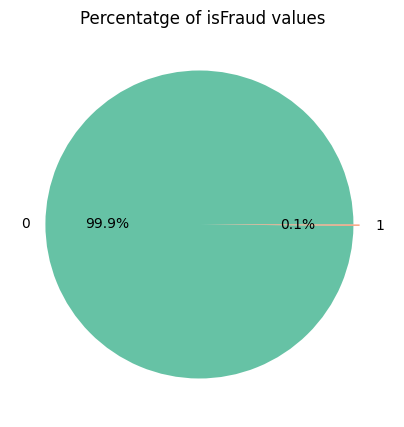

In [12]:
pie_plot(data['isFraud'])


In [13]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

This is an very imbalanced dataset

## Numerical features

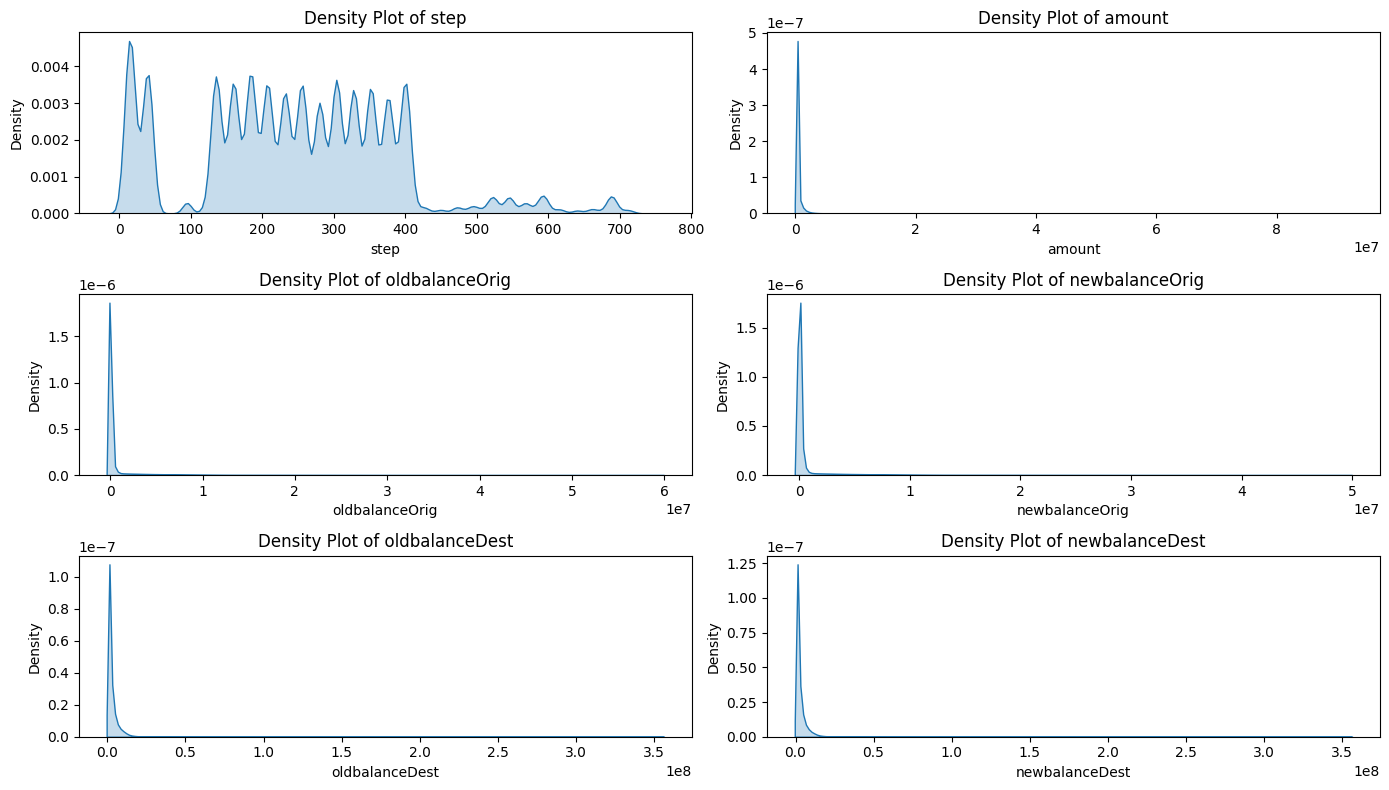

In [14]:
numeric_cols =['step', 'amount','oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest','newbalanceDest']


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axes = axes.flatten()  

for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(data[col], ax=ax, fill=True)
    ax.set_title(f'Density Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

### Step

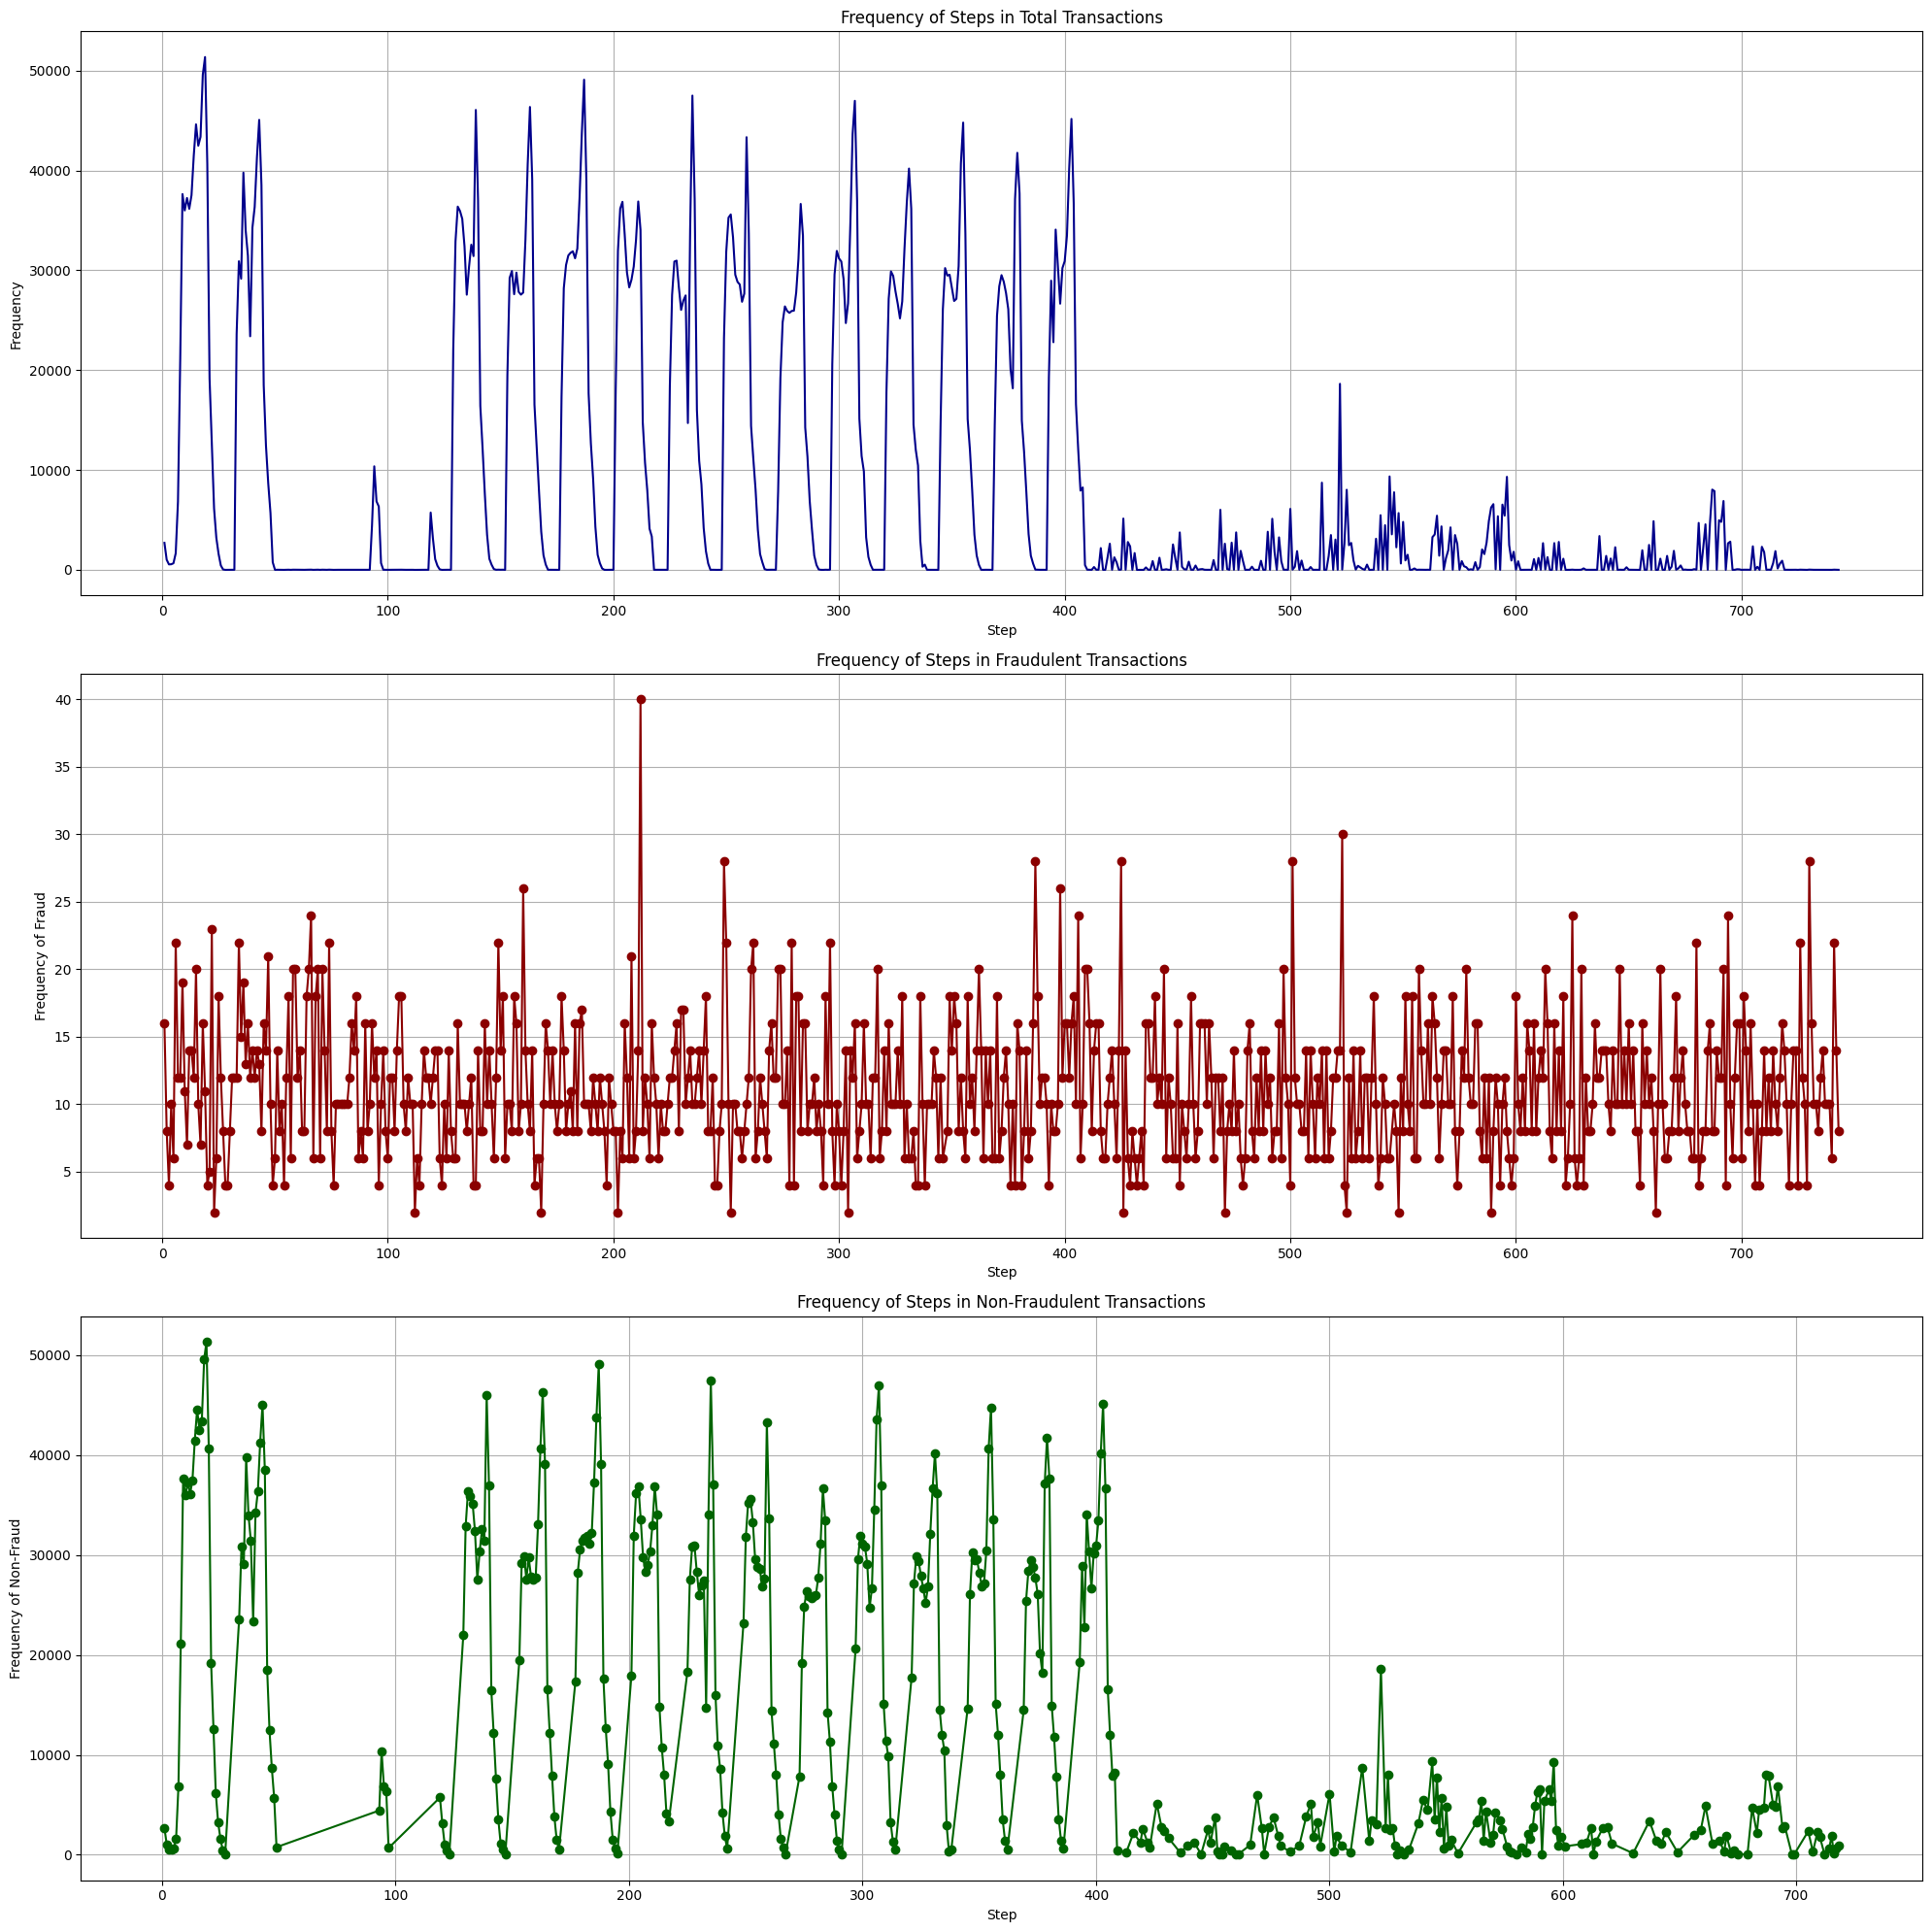

In [15]:
total_value_counts = data['step'].value_counts().sort_index()
fraud_value_counts = data[data['isFraud'] == 1]['step'].value_counts().sort_index()
non_fraud_value_counts = data[data['isFraud'] == 0]['step'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

axes[0].plot(total_value_counts.index, total_value_counts, color='#00008B')
axes[0].set_title("Frequency of Steps in Total Transactions")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

axes[1].plot(fraud_value_counts.index, fraud_value_counts, marker='o', color='#8B0000')
axes[1].set_title("Frequency of Steps in Fraudulent Transactions")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Frequency of Fraud")
axes[1].grid(True)

axes[2].plot(non_fraud_value_counts.index, non_fraud_value_counts, marker='o', color='#006400')
axes[2].set_title("Frequency of Steps in Non-Fraudulent Transactions")
axes[2].set_xlabel("Step")
axes[2].set_ylabel("Frequency of Non-Fraud")
axes[2].grid(True)

plt.tight_layout()
plt.show()

Observations:

For context, 1 step represents 1 hour.

There is a clear pattern that differentiates the behaviour between the fraudulent and the non-fraudulent transactions. 

Non-fraudulent transactions are mostly made in well defined step ranges and slow down when the step is a bit higher than 400. Fraudulent transactions stay constant along the step range. That would be helpful to apply a weighted flag on transactions that take very long time to happen.

A further analysis with more contextualized data could give us some insights about the importance of the steps in the process and the behaviour of fraudsters.

### Type

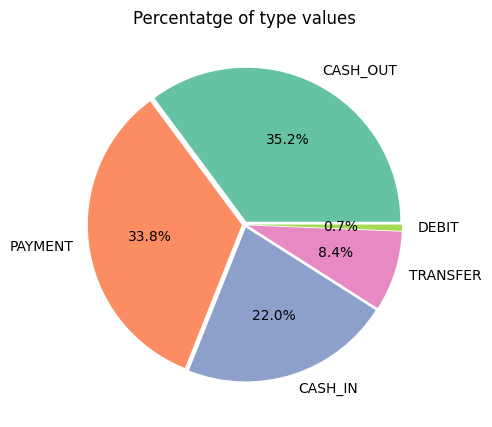

In [16]:
pie_plot(data['type'])

In [17]:
# Which are fraud among every category
fraud_types = df.groupby(['type', 'isFraud'], observed=True).size().reset_index(name='count')
total_transactions = fraud_types.groupby('type', observed = True)['count'].sum().reset_index(name='total')
desc_types = fraud_types.merge(total_transactions, on='type')

desc_types['percentage (%)'] = (desc_types['count'] / desc_types['total'])*100
desc_types.query('isFraud == 1')

,type,isFraud,count,total,percentage (%)
2,CASH_OUT,1,4116,2237500,0.183955
6,TRANSFER,1,4097,532909,0.768799


Observations: 

Fraud happens in two types of transactions: CASH_OUT and TRANSFER.

Those are two cases that could be investigated in order to find solutions for future security improvements.

### Amount

Create ranges of amount transactions

In [18]:
bins = [0, 1000, 10000, 100000, 1000000, 10000000, 100000000]
labels = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']
data['amount_range'] = pd.cut(data['amount'], bins=bins, labels=labels, right=False)

### Distribution of the new variable amount_range

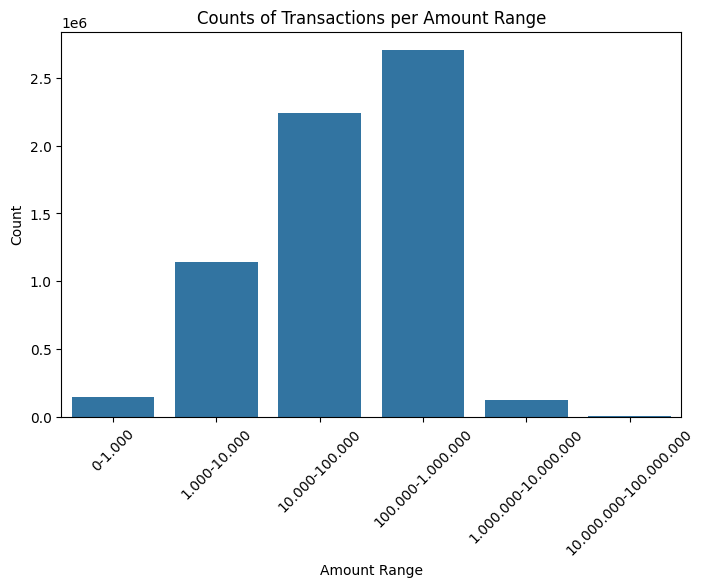

In [19]:
order = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']


plt.figure(figsize=(8, 5))
barplot = sns.countplot(data=data, x='amount_range', order=order)

plt.title('Counts of Transactions per Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Count')

plt.xticks(rotation=45)  
plt.show()


In [20]:
count_data = data.groupby(['amount_range', 'isFraud'], observed=True).size().reset_index(name='count')
total_transactions = count_data.groupby('amount_range', observed = True)['count'].sum().reset_index(name='total')
desc_amount = count_data.merge(total_transactions, on='amount_range')
desc_amount['rate (%)'] = (desc_amount['count'] / desc_amount['total'])*100
desc_amount.query('isFraud == 1') 

,amount_range,isFraud,count,total,rate (%)
1,0-1.000,1,58,142642,0.040661
3,1.000-10.000,1,220,1143361,0.019242
5,10.000-100.000,1,1429,2239253,0.063816
7,100.000-1.000.000,1,3800,2706738,0.140390
9,1.000.000-10.000.000,1,2419,124976,1.935572
11,10.000.000-100.000.000,1,287,5650,5.079646


Observations: 

The biggest ranges have a higher fraud_rate
- 100.000-1.000.000 = 0.14 % (most transactions are inside this amount range)
- 1.000.000-10.000.000 = 1.93 % (very scarce type of amount range)
- 10.000.000-100.000.000 = 5.07% (the less common of all amount ranges)

Fraud is more likely to happen when huge amounts of money are transferred.

In [21]:
null_amount_orig = data.query('amount == 0').sort_values(by = 'nameOrig').reset_index()
print(f' Total amount of accounts that withdrew no money is : {len(null_amount_orig)}')
null_amount_orig 

 Total amount of accounts that withdrew no money is : 16


,index,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0-1.000
1,5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0-1.000
2,6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0-1.000
3,6351226,702,CASH_OUT,0.0,C1461113533,0.0,0.0,C1382150537,107777.02,107777.02,1,0-1.000
4,2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0-1.000
5,6296015,671,CASH_OUT,0.0,C1960007029,0.0,0.0,C459118517,27938.72,27938.72,1,0-1.000
6,6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0-1.000
7,6281485,646,CASH_OUT,0.0,C1997645312,0.0,0.0,C601248796,0.00,0.00,1,0-1.000
8,6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0-1.000
9,6362463,730,CASH_OUT,0.0,C2088151490,0.0,0.0,C1156763710,0.00,0.00,1,0-1.000


Observations:

Fraudsters have been trying to withdraw money from empty accounts. None of them is repeated. Further information about, for example, the account age could help us identify some hidden pattern.

Is there any characteristic in those origin accounts we can find?

In [22]:
nameOrig_list = null_amount_orig['nameOrig'].tolist()

fraud_accounts = data[data['nameOrig'].isin(nameOrig_list)].reset_index()
print(f' Total amount of accounts that withdrew no money is : {len(fraud_accounts)}')
fraud_accounts

 Total amount of accounts that withdrew no money is : 16


,index,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0-1.000
1,3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0-1.000
2,3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0-1.000
3,5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0-1.000
4,5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0-1.000
5,5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0-1.000
6,6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0-1.000
7,6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0-1.000
8,6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0-1.000
9,6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0-1.000


These accounts have only been used to withdraw money fraudulently

### Balances in origin

In [23]:
subset_orig = df[[ 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'isFraud', 'isFlaggedFraud']].copy()
subset_orig['diffBalanceOrig'] = (subset_orig['oldbalanceOrig'] - subset_orig['newbalanceOrig']).round(2)


In [24]:
fraud_subset_orig = subset_orig.query('isFraud == 1').copy().reset_index(drop = True)
corr_fraud_subset_orig = fraud_subset_orig.drop(columns = 'isFraud').corr()
corr_fraud_subset_orig

,amount,oldbalanceOrig,newbalanceOrig,isFlaggedFraud,diffBalanceOrig
amount,1.000000,0.858859,0.338561,0.062365,0.993904
oldbalanceOrig,0.858859,1.000000,0.767811,0.076819,0.850741
newbalanceOrig,0.338561,0.767811,1.000000,0.171402,0.316478
isFlaggedFraud,0.062365,0.076819,0.171402,1.000000,-0.026872
diffBalanceOrig,0.993904,0.850741,0.316478,-0.026872,1.000000


In [25]:
non_fraud_subset_orig = subset_orig.query('isFraud == 0').copy().reset_index(drop = True)
corr_non_fraud_subset_orig = non_fraud_subset_orig.drop(columns = 'isFraud').corr()
corr_non_fraud_subset_orig

,amount,oldbalanceOrig,newbalanceOrig,isFlaggedFraud,diffBalanceOrig
amount,1.000000,-0.009092,-0.008521,NaN,-0.012479
oldbalanceOrig,-0.009092,1.000000,0.999417,NaN,-0.340197
newbalanceOrig,-0.008521,0.999417,1.000000,NaN,-0.372112
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN
diffBalanceOrig,-0.012479,-0.340197,-0.372112,NaN,1.000000


Observations: 

fraud_subset_orig correlation tables shows high correlation between amount and oldbalanceOrig with diffBalanceOrig. Fraudsters try to extract the whole amount of money that users have inside the account. That could be a nice flag. 

non_fraud_subset_orig confirms that this behaviour doesn't appear on legitimate transactions. The NaN values of isFlaggedFraud just show that there is no variability in the results so the previous model works very well not giving False Positives

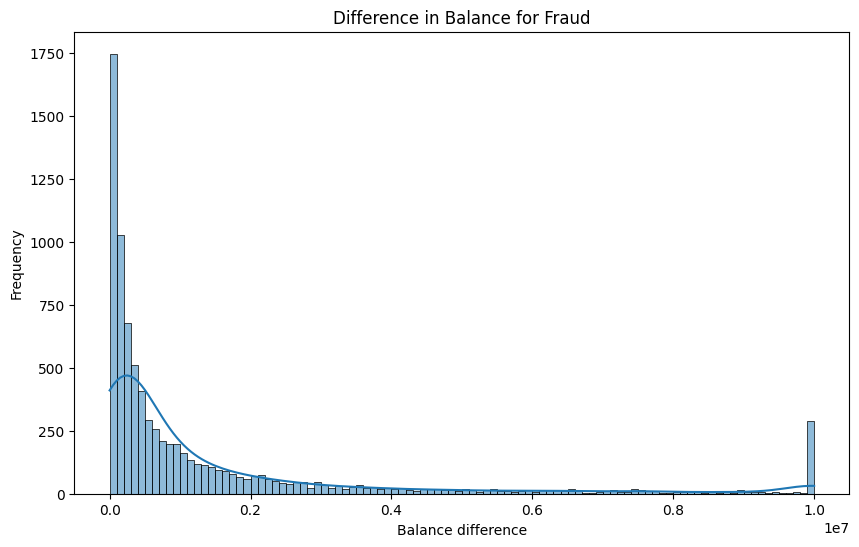

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_subset_orig['diffBalanceOrig'], bins=100, kde=True)
plt.title('Difference in Balance for Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

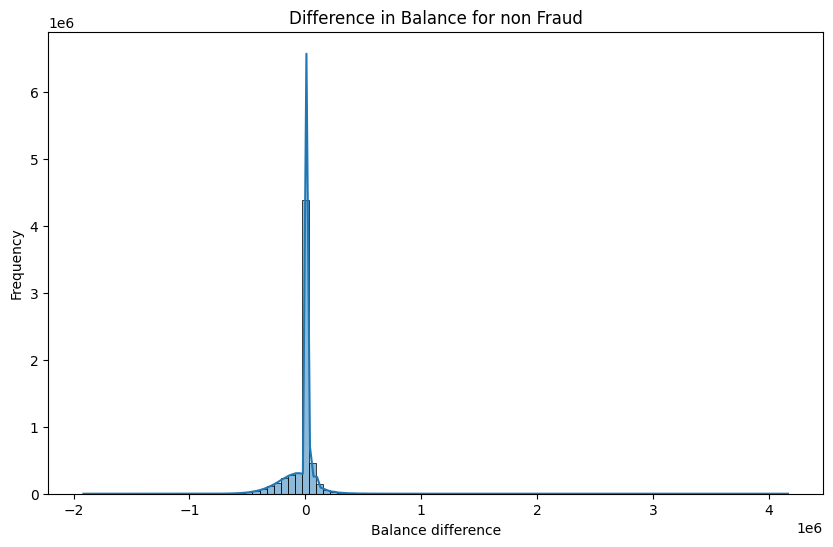

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_subset_orig['diffBalanceOrig'], bins=100, kde=True)
plt.title('Difference in Balance for non Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

### Balances in destination

In [28]:
subset_dest = df[[ 'amount', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']].copy()
subset_dest['diffBalanceDest'] = (subset_dest['newbalanceDest'] - subset_dest['oldbalanceDest']).round(2)


In [29]:
fraud_subset_dest = subset_dest.query('isFraud == 1').copy().reset_index(drop = True)
corr_fraud_subset_dest = fraud_subset_dest.drop(columns = 'isFraud').corr()
corr_fraud_subset_dest

,amount,oldbalanceDest,newbalanceDest,isFlaggedFraud,diffBalanceDest
amount,1.000000,-0.007037,0.299403,0.062365,0.642864
oldbalanceDest,-0.007037,1.000000,0.880353,-0.007207,0.056390
newbalanceDest,0.299403,0.880353,1.000000,-0.014465,0.523208
isFlaggedFraud,0.062365,-0.007207,-0.014465,1.000000,-0.017499
diffBalanceDest,0.642864,0.056390,0.523208,-0.017499,1.000000


In [30]:
non_fraud_subset_dest = subset_dest.query('isFraud == 0').copy().reset_index(drop = True)
corr_non_fraud_subset_dest = non_fraud_subset_dest.drop(columns = 'isFraud').corr()
corr_non_fraud_subset_dest

,amount,oldbalanceDest,newbalanceDest,isFlaggedFraud,diffBalanceDest
amount,1.000000,0.298774,0.464114,NaN,0.850764
oldbalanceDest,0.298774,1.000000,0.976723,NaN,0.233333
newbalanceDest,0.464114,0.976723,1.000000,NaN,0.436486
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN
diffBalanceDest,0.850764,0.233333,0.436486,NaN,1.000000


Observations:

In this case the variable amount is the most correlated to the difference in balances. More research could be done here since there must be some missing data because balances in the origin and the destination don't match so that would mean there is some sort of by-pass that sends the money somewhere else? 

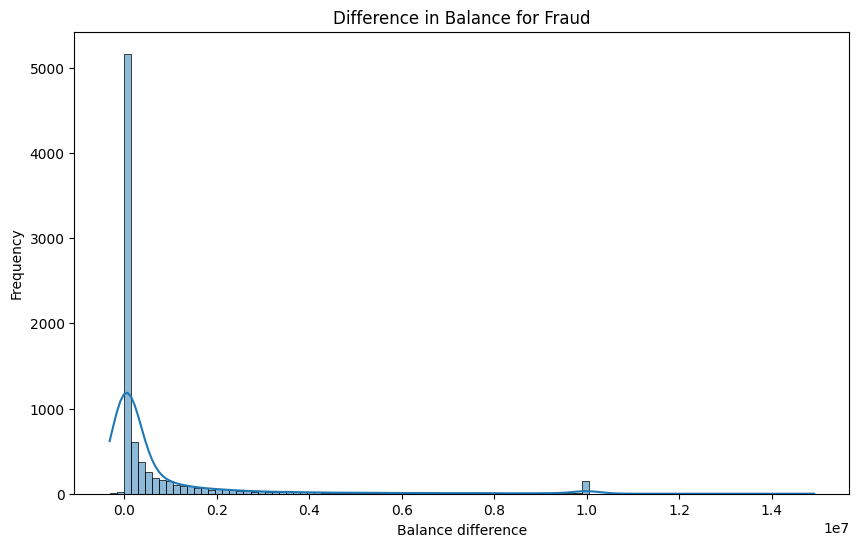

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_subset_dest['diffBalanceDest'], bins=100, kde=True)
plt.title('Difference in Balance for Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

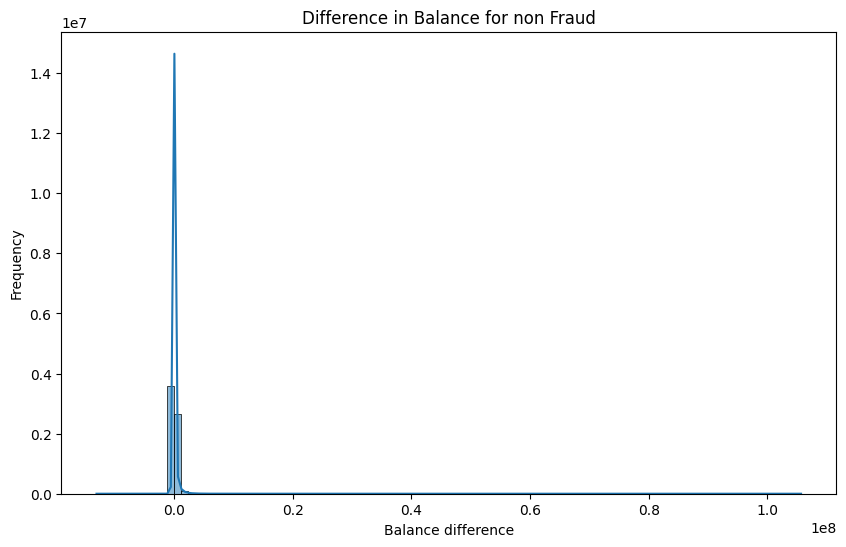

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_subset_dest['diffBalanceDest'], bins=100, kde=True)
plt.title('Difference in Balance for non Fraud')
plt.xlabel('Balance difference')
plt.ylabel('Frequency')
plt.show()

### Name Origin

Can we find users in the origin with mixed fraudulent and not fraudulent behaviour? Are they only doing fraud? 

In [33]:
subset_nameorig = df[['amount', 'nameOrig', 'nameDest', 'isFraud']].copy()
subset_nameorig

,amount,nameOrig,nameDest,isFraud
0,9839.64,C1231006815,M1979787155,0
1,1864.28,C1666544295,M2044282225,0
2,181.00,C1305486145,C553264065,1
3,181.00,C840083671,C38997010,1
4,11668.14,C2048537720,M1230701703,0
...,...,...,...,...
6362615,339682.13,C786484425,C776919290,1
6362616,6311409.28,C1529008245,C1881841831,1
6362617,6311409.28,C1162922333,C1365125890,1
6362618,850002.52,C1685995037,C2080388513,1


In [34]:
nameorig_counts = subset_nameorig.groupby('nameOrig').size()
nameorig_common = nameorig_counts[nameorig_counts > 1]
subset_nameorig_repeated = subset_nameorig[subset_nameorig['nameOrig'].isin(nameorig_common.index)]

In [35]:
fraudulent = subset_nameorig_repeated[subset_nameorig_repeated['isFraud'] == 1]['nameOrig'].unique()
non_fraudulent = subset_nameorig_repeated[subset_nameorig_repeated['isFraud'] == 0]['nameOrig'].unique()

# Encontrar la intersección de ambos arrays
common_fraud_nonfraud = np.intersect1d(fraudulent, non_fraudulent)
common_fraud_nonfraud

array(['C1015856166', 'C1044518032', 'C10982843', 'C1118399210',
       'C1127304441', 'C1191696703', 'C1498185758', 'C1627918307',
       'C171834973', 'C1851065642', 'C1863683348', 'C1882162040',
       'C1885333477', 'C1899367925', 'C2004363483', 'C357911107',
       'C431038121', 'C432562518', 'C471097879', 'C483009518',
       'C570470570', 'C635739031', 'C686187434', 'C803411135',
       'C812001868', 'C850961884', 'C876181265', 'C929585215'],
      dtype=object)

In [59]:
repeated_names_orig = data[data['nameOrig'].isin(common_fraud_nonfraud)].sort_values(by = 'nameOrig', ascending = True).reset_index(drop = True)
repeated_names_orig.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,257,PAYMENT,2496.73,C1015856166,0.00,0.00,M183948217,0.00,0.00,0,1.000-10.000
1,453,CASH_OUT,2600970.32,C1015856166,2600970.32,0.00,C1424612838,2111795.89,4712766.22,1,1.000.000-10.000.000
2,19,CASH_IN,78603.46,C1044518032,1592298.26,1670901.72,C1544000930,156378.24,0.00,0,10.000-100.000
3,388,CASH_OUT,20393.12,C1044518032,20393.12,0.00,C1479987881,293446.62,313839.74,1,10.000-100.000
4,335,PAYMENT,5538.46,C10982843,29270.00,23731.54,M1708468225,0.00,0.00,0,1.000-10.000


In [62]:
X = repeated_names_orig[['step', 'amount', 'oldbalanceOrig','newbalanceOrig', 'oldbalanceDest',	'newbalanceDest']]

y = repeated_names_orig['isFraud']

kmeans = KMeans(n_clusters=3, random_state= 42)  
kmeans.fit(X)



KMeans(n_clusters=3, random_state=42)

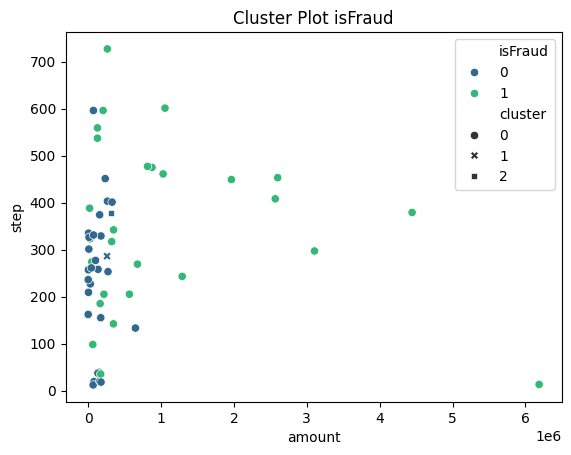

In [63]:
# Agregar las etiquetas de cluster al DataFrame
repeated_names_orig['cluster'] = kmeans.labels_

sns.scatterplot(data=repeated_names_orig, x='amount', y='step', hue='isFraud', style='cluster', palette='viridis')
plt.title('Cluster Plot isFraud')
plt.xlabel('amount')
plt.ylabel('step')
plt.show()

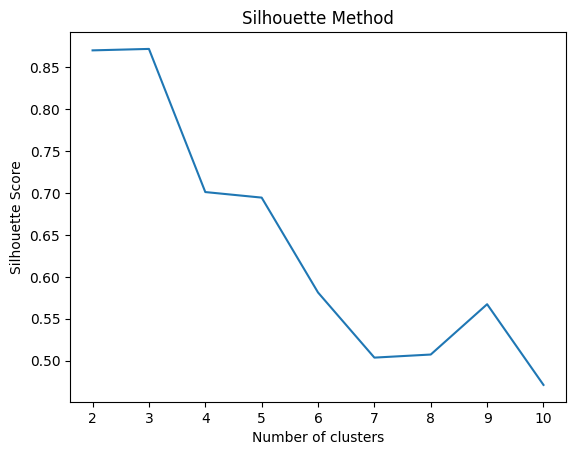

In [69]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

Factor Analysis of Mixed Data (FAMD) on 

In [ ]:
help(prince.FAMD)

In [ ]:
# Transformando el conjunto de datos
coordinates = famd.row_coordinates(repeated_names_orig[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'amount_range']])

# Gráfico de dispersión de los dos primeros componentes principales
plt.figure(figsize=(10, 8))
plt.scatter(coordinates[0], coordinates[1], c=repeated_names_orig['isFraud'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Fraud')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('FAMD - First Two Principal Components')
plt.show()


In [ ]:
subset_nameorig.query('nameOrig == "C1015856166"')

In [ ]:

pd.set_option('display.max_rows', 100)
sub_amount_orig.head(100)

In [ ]:
sub_amount = subset_orig.loc[(subset_orig['amount'] != subset_orig['amount_moved']) & (subset_orig['isFraud'] == 1)]


In [ ]:
subset_orig.query('isFraud == 1')

In [ ]:
data.query('nameOrig == "C1303719003"')

In [ ]:
data.query('amount == 0').sort_values(by = 'nameDest')

In [ ]:
data.loc[df.duplicated(subset ='nameOrig')]

In [ ]:
data.query('nameOrig == "C850961884"')

In [ ]:
data.loc[data.duplicated(subset =['nameOrig', 'nameDest'])]

Ideas:

- Check duplicated with query on names orig and dest that are Fraud == 1

In [ ]:
skewness 

In [ ]:
kurtosis